In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from matplotlib.pyplot import specgram
import math
from random import shuffle

TODO:

HDF5
RCNN

In [13]:
#hop 10ms, window 40
def appendSounds(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    iterator = 0
    while iterator+16<=mel.shape[1]:
        data.append(mel[:,iterator:iterator+16].flatten())
        labels.append(classNumber)
        iterator+=16

In [14]:
#hop 10ms, window 40
def appendTracks(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    data.append(mel)
    labels.append(classNumber)

In [15]:
from multiprocessing import Process, Lock, Pipe,Event
import time
from keras import utils


allData,allLabels=[],[]
trainData,trainLabels= [],[]
tuneData,tuneLabels=[],[]
testData,testLabels=[],[]
#function to extract data using multiprocessing
def add(x,c):
    tempdata,templabels = [],[]
    if x<9:
        #split for training set - loses information about which clip batch comes from 
        for file in glob.glob(x):
            appendSounds(tempdata, templabels, file)
    else:
        #split for testing set - presumes batches of sound within clip
        for file in glob.glob(x):
            appendTracks(tempdata, templabels, file)
            
    c.send(zip(tempdata, templabels))
    del tempdata,templabels
        
ts = time.time()

#doing actual multiprocessing extraction
if __name__ == '__main__':
    threads= []
    connections=[0]*10
    lock = Lock()
    for x in xrange(1,9):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    fold = 1
    for x,y in zip(threads,connections):
        tD, tL = zip(*y.recv())
        if fold <= 6:
            trainData += tD
            trainLabels += tL
        elif fold <= 8 :
            tuneData += tD
            tuneLabels += tL
        else:
            testData += tD
            testLabels += tL
        fold+=1
        
    #save data into numpy array, change classes label using onehot encoding
    trainData, trainLabels = np.array(trainData), np.array(utils.to_categorical(trainLabels, num_classes=10))
    tuneData, tuneLabels = np.array(tuneData), np.array(utils.to_categorical(tuneLabels, num_classes=10))
    testData, testLabels = np.array(testData), np.array(utils.to_categorical(testLabels, num_classes=10))
    
    print "I'm done, time was:" , time.time()-ts

I'm done, time was: 513.53489995


In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers
from random import uniform
from math import pow
rates2 = []

#standard NN - was fine tuned for another example, outdated right now

LR,L2= 0.008,0.00207
net = Sequential()
net.add(Dense(512, activation='relu', input_dim=1024,
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.5))
net.add(Dense(256, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.3))
net.add(Dense(64, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.1))
net.add(Dense(10, activation='softmax'))
net.compile(loss='categorical_crossentropy',
           optimizer = SGD(lr=LR,decay=1e-6, momentum=0.9,nesterov=True),
           metrics = ['accuracy'])

net.fit(trainData, trainLabels, epochs = 100, batch_size=128, verbose=0)
rates2.append([net.evaluate(tuneData,tuneLabels, batch_size=16384)[1],
             net.evaluate(trainData,trainLabels, batch_size=16384)[1],
             LR,L2])
print ("Tune score: %.3f Train score: %.3f Learning rate: %f L2 reg: %f" %(rates2[-1][0],rates2[-1][1],LR, L2))

23987/23987 [==============================] - 0s     
Tune score: 0.294 Train score: 0.351 Learning rate: 0.008000 L2 reg: 0.002070


In [17]:
#reshape training and tune set so it fits CNN

trainData=np.reshape(trainData,(trainData.shape[0],64,16))
tuneData=np.reshape(tuneData,(tuneData.shape[0],64,16))
trainData=np.expand_dims(trainData,axis=3)
tuneData=np.expand_dims(tuneData,axis=3)
print trainData.shape, tuneData.shape

(23987, 64, 16, 1) (7322, 64, 16, 1)


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD

#CNN working on batches of image, accuracy up to 72%

model = Sequential()
model.add(ZeroPadding2D(padding = (1,1), input_shape=(64, 16, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

model.fit(np.concatenate((trainData,tuneData),axis=0), np.concatenate((trainLabels,tuneLabels),axis=0),
          batch_size=512, epochs=40,verbose=2)

Epoch 1/40
186s - loss: 1.6351 - acc: 0.4361
Epoch 2/40
184s - loss: 1.0829 - acc: 0.6322
Epoch 3/40
184s - loss: 0.8629 - acc: 0.7212
Epoch 4/40
183s - loss: 0.7208 - acc: 0.7657
Epoch 5/40
184s - loss: 0.6107 - acc: 0.8026
Epoch 6/40
183s - loss: 0.5485 - acc: 0.8204
Epoch 7/40
184s - loss: 0.4927 - acc: 0.8395
Epoch 8/40
184s - loss: 0.4472 - acc: 0.8537
Epoch 9/40
184s - loss: 0.4161 - acc: 0.8628
Epoch 10/40
184s - loss: 0.3884 - acc: 0.8709
Epoch 11/40
184s - loss: 0.3612 - acc: 0.8805
Epoch 12/40
185s - loss: 0.3384 - acc: 0.8864
Epoch 13/40
185s - loss: 0.3251 - acc: 0.8928
Epoch 14/40
185s - loss: 0.3074 - acc: 0.8958
Epoch 15/40
185s - loss: 0.2874 - acc: 0.9038
Epoch 16/40
185s - loss: 0.2814 - acc: 0.9044
Epoch 17/40
186s - loss: 0.2678 - acc: 0.9081
Epoch 18/40
186s - loss: 0.2518 - acc: 0.9143
Epoch 19/40
186s - loss: 0.2411 - acc: 0.9197
Epoch 20/40
185s - loss: 0.2338 - acc: 0.9210
Epoch 21/40
186s - loss: 0.2225 - acc: 0.9259
Epoch 22/40
187s - loss: 0.2171 - acc: 0.92

In [43]:
#final scoring function. isnt used in training.
#CNN predicts classes for all parts of clip and sums probablities, chooses best
#scores is confusion matrix
scores = np.zeros((10,10))
missed = 0
for track,label in zip(testData,testLabels):
    tempD =[]
    iterator = 0
    if track.shape[1]<16:
        t = track.shape[1]
        b = np.zeros((64,16))
        b[:, :-16+t]= track
        tempD.append(b)
    while (iterator+16<=track.shape[1]):
        tempD.append(track[:,iterator:iterator+16])
        iterator+=16
    tempD= np.array(tempD)
    tempD = np.expand_dims(tempD, axis=3)
    predicted = model.predict(tempD, batch_size=1, verbose=2)
    scores[predicted.sum(axis=0).argmax(),label.argmax()]+=1

accuracy = scores.trace()/scores.sum()    
print accuracy

0.705989110708


[[  80.    0.    1.    5.    2.   10.    1.    3.    3.    1.]
 [   0.   50.    0.    0.    2.    0.    0.    0.    0.    0.]
 [  11.    2.  144.   28.   10.   24.    0.    1.   24.   16.]
 [   6.    2.   36.  144.    4.    2.   24.    0.   11.    1.]
 [  51.    1.    2.    6.  139.    0.    1.   67.    1.    2.]
 [   1.    0.    8.    6.    0.  125.    0.    3.    4.    0.]
 [   0.    0.    1.    0.    1.    0.   36.    0.    0.    0.]
 [  24.    1.    1.    2.   33.   11.    0.  104.    0.    0.]
 [   4.    0.    4.    3.    4.    0.    0.    0.  120.    2.]
 [  23.    9.    3.    6.    5.   10.    1.    0.    2.  178.]]


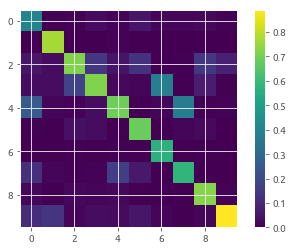

In [146]:
from sklearn.preprocessing import normalize

#prints scores and graphic version
print scores
normscores =normalize(scores,norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()

Some charts used in finetuning of previous NN

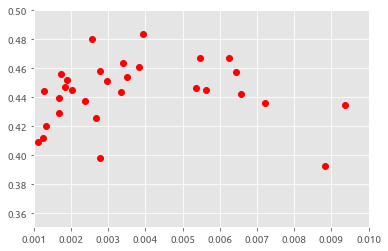

In [43]:
plt.plot(rates[:,2],rates[:,0],'ro')
plt.axis([0.001,0.01,0.35,0.5])
plt.show()
#128 batch - f(learning_Rate)=score

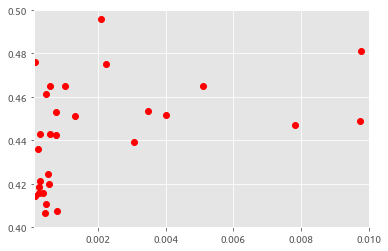

In [50]:
plt.plot(rates1[:,3],rates1[:,0],'ro')
plt.axis([0.0001,0.01,0.4,0.5])
plt.show()
#128 batch - f(L2 lambda)=score, lr=0.0038